In [1]:
"""
    IMPORTING LIBS
"""
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import os
import json
import pickle
from tqdm import tqdm

import dgl
import networkx as nx

import torch
from torch.utils.data import DataLoader
"""
    IMPORTING CUSTOM MODULES/METHODS
"""
from data.data import LoadData 

Using backend: pytorch


In [2]:
class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self

"""
    GPU Setup
"""
def gpu_setup(use_gpu, gpu_id):
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)  

    if torch.cuda.is_available() and use_gpu:
        print('cuda available with GPU:',torch.cuda.get_device_name(0))
        device = torch.device("cuda")
    else:
        print('cuda not available')
        device = torch.device("cpu")
    return device

In [3]:
"""
    DEVICE
"""

device = gpu_setup(True, 0)


"""
    CONFIG
"""

config = open('configs/molecules_GraphTransformer_LapPE_ZINC_500k_sparse_graph_BN.json')
config = json.load(config)
params = config['params']
net_params = config['net_params']

cuda available with GPU: Quadro P2200


In [4]:
"""
    DATASET
"""

DATASET_NAME = config['dataset']
dataset = LoadData(DATASET_NAME)

if net_params['lap_pos_enc']:
    print("[!] Adding Laplacian positional encoding.")
    dataset._add_laplacian_positional_encodings(net_params['pos_enc_dim'])
    print("[I] Encoding addition over.")

if net_params['wl_pos_enc']:
    print("[!] Adding WL positional encoding.")
    dataset._add_wl_positional_encodings()
    print("[I] Encoding addition over.")
    
trainset, valset, testset = dataset.train, dataset.val, dataset.test

train_loader = DataLoader(trainset, batch_size=params['batch_size'], shuffle=True, collate_fn=dataset.collate)
val_loader = DataLoader(valset, batch_size=params['batch_size'], shuffle=False, collate_fn=dataset.collate)
test_loader = DataLoader(testset, batch_size=params['batch_size'], shuffle=False, collate_fn=dataset.collate)

[I] Loading dataset ZINC...
train, test, val sizes : 10000 1000 1000
[I] Finished loading.
[I] Data load time: 3.9495s
[!] Adding Laplacian positional encoding.


/Data/tegucigalpa/miniconda3/envs/graph_transformer/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: DGLGraph.adjacency_matrix_scipy is deprecated. Please replace it with:

	DGLGraph.adjacency_matrix(transpose, scipy_fmt="csr").

  return warnings.warn(message, category=category, stacklevel=1)


[I] Encoding addition over.


In [5]:
"""
    MODEL
"""
from nets.molecules_graph_regression.load_net import gnn_model

MODEL_NAME = config['model']

net_params['device'] = device
net_params['gpu_id'] = config['gpu']['id']
net_params['batch_size'] = params['batch_size']
net_params['num_atom_type'] = dataset.num_atom_type
net_params['num_bond_type'] = dataset.num_bond_type

print("[!] Loading model.")
model = gnn_model(MODEL_NAME, net_params)
model = model.to(device)
print("[I] Model loaded.")

[!] Loading model.
[I] Model loaded.


In [6]:
def get_all_features(data_loader):
    nfeatures = []
    efeatures = []
    for iter, (batch_graphs, batch_targets) in tqdm(enumerate(data_loader)):
        for graph in dgl.unbatch(batch_graphs):
            graph_nfeat = graph.ndata['feat'].to(device).cpu()
            graph_efeat = graph.edata['feat'].to(device).cpu()
            for nfeat in graph_nfeat:
                if nfeat not in nfeatures:
                    nfeatures+=[nfeat.item()]
            for efeat in graph_efeat:
                if efeat not in efeatures:
                    efeatures+=[efeat.item()]
    return nfeatures, efeatures

In [7]:
cm = plt.get_cmap('gist_rainbow')
atom_colors = [cm(1.*i/dataset.num_atom_type) for i in range(dataset.num_atom_type)]

In [8]:
(batch_graphs, batch_targets) = next(iter(train_loader))

batch_graphs = batch_graphs.to(device)
batch_x = batch_graphs.ndata['feat'].to(device)  # num x feat
batch_e = batch_graphs.edata['feat'].to(device)

batch_lap_pos_enc = batch_graphs.ndata['lap_pos_enc'].to(device)
sign_flip = torch.rand(batch_lap_pos_enc.size(1)).to(device)
sign_flip[sign_flip>=0.5] = 1.0; sign_flip[sign_flip<0.5] = -1.0
batch_lap_pos_enc = batch_lap_pos_enc * sign_flip.unsqueeze(0)

In [9]:
output = model(batch_graphs, batch_x, batch_e, batch_lap_pos_enc)

In [10]:
mapping = {'C': 0,'O': 1,'N': 2,'F': 3,'C H1': 4,'S': 5,'Cl': 6,'O -': 7,'N H1 +': 8,'Br': 9,'N H3 +': 10,'N H2 +': 11,'N +': 12,'N -': 13,'S -': 14,'I': 15,'P': 16,'O H1 +': 17,'N H1 -': 18,'O +': 19,'S +': 20,'P H1': 21,'P H2': 22,'C H2 -': 23,'P +': 24,'S H1 +': 25,'C H1 -': 26,'P H1 +': 27}
mapping = {v:k for k,v in mapping.items()}

/Data/tegucigalpa/miniconda3/envs/graph_transformer/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Data/tegucigalpa/miniconda3/envs/graph_transformer/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


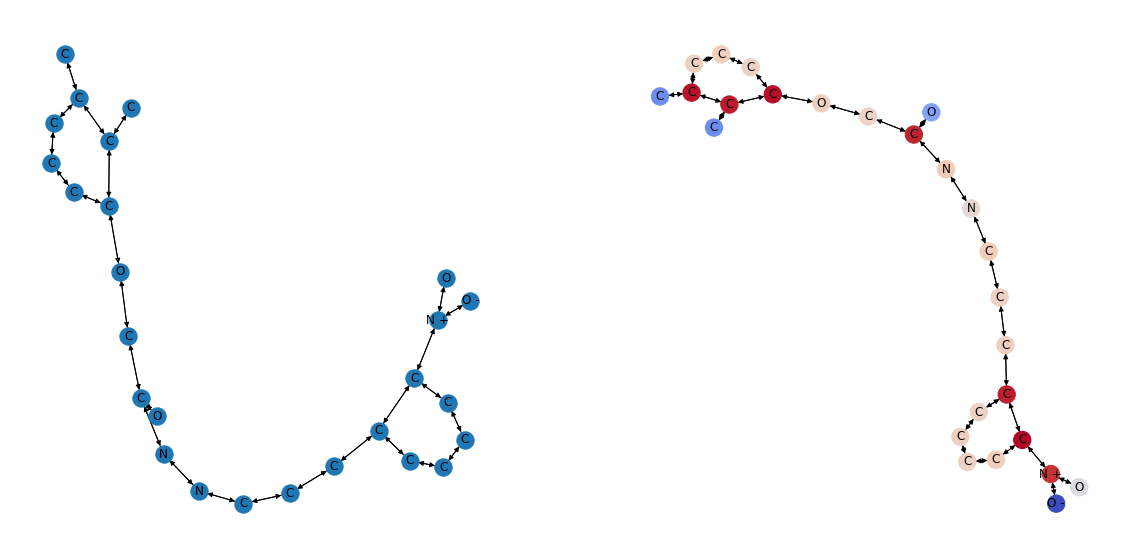

Expected solubility : 1.659371018409729 . 
Solubility predicted : 0.0016541127115488052 . 

 ---------------------------------- 




In [11]:
graph = dgl.unbatch(batch_graphs)[0]
x = graph.ndata['feat'].to(device)
e = graph.edata['feat'].to(device)
z = torch.squeeze(torch.mean(graph.ndata['z'], dim=1))
scores = z.cpu().detach().numpy()
batch_targets = batch_targets.to(device)

G = dgl.to_networkx(graph.cpu())

plt.figure(1, figsize=(20,10))
plt.subplot(121)
nx.draw(G,
        with_labels = True,
        labels = {i : mapping[x[i].item()] for i in range(x.shape[0])},
        pos = nx.spring_layout(G))

plt.subplot(122)
nx.draw(G,
        with_labels = True,
        node_color = scores,
        labels = {i : mapping[x[i].item()] for i in range(x.shape[0])},
        cmap = plt.cm.coolwarm,
        pos = nx.spring_layout(G, iterations=100))
plt.show()
print('Expected solubility : {} . \nSolubility predicted : {} . \n\n ---------------------------------- \n\n'.format(batch_targets[0].item(), output[0].item()))